<a href="https://colab.research.google.com/github/fellowship/deep-and-wide-bandit/blob/dev/Wide_and_Deep_Models/wd_models_jenny/wide_deep_model_BLR_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Wide and Deep model with Thompson Sampling


Take the last layer representation of the neural network (concatenated output from deep and wide networks), use Bayesian linear regression + Thompson sampling to selected best action. 


In [1]:
import os
import gc
import sys
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import random
import torch
import torch.nn as nn
import time
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import invgamma
from IPython.display import clear_output
from matplotlib import pyplot as plt 
from tqdm import tqdm

In [2]:
!pip install space-bandits
from space_bandits import BanditAlgorithm, NeuralBandits
clear_output()

In [ ]:
## plug in gdrive to load the data from gdrive
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
## path to the contextual_dataset_wu.py file
path = '/content/drive/MyDrive/Fellowship_Deep_and_Wide_Bandit/'
sys.path.append(path)

from contextual_dataset_wu import ContextualDataset

In [6]:
## Load dataset

p = 0.002  # Read 1% of the lines
## keep the header, then take only 1% of lines
## if random from [0,1] interval is greater than 0.01 the row will be skipped
data_snippet = pd.read_csv(
         path+'data_snippet.csv',
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p ## skip rows unless randomly generated number < p
)

#data_snippet_all = pd.read_csv(path+'data_snippet.csv')

In [7]:
## Use label encoding for campaign_type
data_snippet["campaign_type"] = data_snippet["campaign_type"].astype('category')
data_snippet["campaign_type_cat"] = data_snippet["campaign_type"].cat.codes

## Set rewards
data_snippet['rewards'] = data_snippet['opened'] * 5
data_snippet['rewards'][data_snippet['unsub']==1] = -10
data_snippet['rewards'][data_snippet['opened']==0] = -4
data_snippet['rewards'] = data_snippet['rewards'] + data_snippet['rev_3dv2'] / 10

clear_output()

In [8]:
## Define Dataset for data snippet
class BanditTestDataset(Dataset):
    def __init__(self, data, user_col, context_col, rewards_col, action_col=None):
        super(BanditTestDataset, self).__init__()
        ## data - pandas dataframe
        ## user_col - user IDs column name
        ## action_col - action column name
        ## context_col - context column names
        ## rewards_col - reward column name
        self.user_ids = data[user_col]
        self.context = data[context_col]
        self.rewards = data[rewards_col]
        if action_col != None:
          self.actions = data[action_col]
        
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        ## returns numpy arrays
        user_id = self.user_ids.iloc[index].values[0]
        context = self.context.iloc[index].values
        reward = self.rewards.iloc[index].values[0]
        reward_orig = reward ## copy the reward before changing it
        if action_col != None:
          action = self.actions.iloc[index].values[0]
        else:
          ## Randomly choose to send or not send email
          randnum = random.random() ## draw a random number between 0 and 1
          threshold = 0.5 ## if thresehold = 0.2, send email 80% of the time
          if randnum >= threshold:
            action = 1 ## send email if random number larger than threshold, get the associated reward
          else:
            action = 0 ## don't send email if random number smaller than threshold
            reward = reward * -1. ## Get opposite reward compared to send email

        return user_id, action, context, reward, reward_orig

In [9]:
## Split into train and val sets. Create dataloaders.

train, val = train_test_split(data_snippet, test_size=0.3)

user_col = ['riid']
context_col = ['retention_score','recency_score','frequency_score','campaign_type_cat']
rewards_col = ['rewards']
action_col = None

batch_size = 2048

train_dataset = BanditTestDataset(train, user_col, context_col, rewards_col, action_col=None)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
del train

val_dataset = BanditTestDataset(val, user_col, context_col, rewards_col, action_col=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
del val

In [10]:
num_actions = 2 ## Send email or not send
num_features = len(context_col)
num_users = data_snippet[user_col].nunique()[0] + 1
print("Number of actions:", num_actions)
print("Number of features:", num_features)
print("Number of users:", num_users)

Number of actions: 2
Number of features: 4
Number of users: 12231


In [11]:
class Wide_Model(nn.Module):
    def __init__(self, embed_size=100, n_action=2, embed_dim=64):
        ## Learns expected reward for each action given User ID
        ## Uses embeddings to 'memorize' individual users
        ## embed_size - size of the dictionary of embeddings
        ## embed_dim -  size of each embedding vector
        ## n_action - number of possible actions
        super(Wide_Model, self).__init__()
        self.embed_size = embed_size
        self.n_action = n_action
        self.embed_dim = embed_dim
        
        self.embedding = nn.Embedding(self.embed_size, self.embed_dim)
        self.lr = nn.Linear(self.embed_dim, self.n_action)
    
    def forward(self, user_idx, get_rep = False):
        ## Input: user ID
        ## get_rep - get the representations for training 
        x = self.embedding(user_idx)
        rep = x
        x = self.lr(x)

        if get_rep == True:
          return rep
        else:
          return x.squeeze(axis=0)
    
    def get_representation(self, user_id):
        """
        Given input user_id, returns the embedding as the 
        "z" vector. Used for Bayesian linear regression + TS
        """
        x = user_id
        with torch.no_grad():
            x = self.embedding(x)
        return x


class Deep_Model(nn.Module):
    def __init__(self, context_size=5, layer_sizes=[50], n_action=2):
        ## Learns expected reward for each action given context
        ## layer_sizes (list of integers): defines neural network architecture: n_layers = len(layer_sizes), 
        ## value is per-layer width. (default [50])
        super(Deep_Model, self).__init__()
        self.context_size = context_size
        self.layer_sizes = layer_sizes
        self.n_action = n_action

        self.layers = []
        self.build_model()
        self.activation = nn.ReLU()
        ##self.activation = nn.Sigmoid()
    
    def build_layer(self, inp_dim, out_dim):
        """Builds a layer in deep model """

        layer = nn.modules.linear.Linear(inp_dim,out_dim)
        nn.init.uniform_(layer.weight)
        name = f'layer {len(self.layers)}'
        self.add_module(name, layer)
        return layer
    
    def build_model(self):
        """
        Defines the actual NN model with fully connected layers.
        """
        for i, layer in enumerate(self.layer_sizes):
            if i==0:
                inp_dim = self.context_size
            else:
                inp_dim = self.layer_sizes[i-1]
            out_dim = self.layer_sizes[i]
            new_layer = self.build_layer(inp_dim, out_dim)
            self.layers.append(new_layer)

        output_layer = self.build_layer(out_dim, self.n_action)
        self.layers.append(output_layer)

    def forward(self, contexts, get_rep = False):
        """forward pass of the neural network"""
        ## Input: context
        ## get_rep - get the representations for training
        x = contexts
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers)-1:
                x = self.activation(x)
                rep = x
        if get_rep == True:
          return rep
        else:
          return x.squeeze(axis=0)
    
    def get_representation(self, contexts):
        """
        Given input contexts, returns representation
        "z" vector.
        """
        x = contexts
        with torch.no_grad():
            for i, layer in enumerate(self.layers[:-1]):
                x = layer(x)
                x = self.activation(x)
        return x
  

class Wide_and_Deep_Model(nn.Module):
    def __init__(self, context_size=5, deep_layer_sizes=[50,100], n_action=2, embed_size=100, wide_embed_dim=64):
        super(Wide_and_Deep_Model, self).__init__()
        ## Combines the Wide model and Deep model
        self.n_action = n_action
        self.context_size = context_size
        self.deep_layer_sizes = deep_layer_sizes
        self.embed_size = embed_size
        self.wide_embed_dim = wide_embed_dim

        self.lr_cred = nn.Linear(self.n_action*2, self.n_action)
        self.lr_crep = nn.Linear(self.wide_embed_dim + self.deep_layer_sizes[-1], self.n_action)
        
        self.wide_model = Wide_Model(embed_size=self.embed_size, n_action=self.n_action, embed_dim=self.wide_embed_dim)
        self.deep_model = Deep_Model(context_size=self.context_size, layer_sizes=self.deep_layer_sizes, n_action=self.n_action)
    
    def forward(self, wide_input, deep_input, combine_method='add'):

        possible_combine_methods = ['add','concat_reward','concat_reward_llr','concat_representation_llr']
        if combine_method not in possible_combine_methods:
          raise NameError('combine_method must be "add","concat_reward","concat_reward_llr", or "concat_representation_llr"')

        if combine_method == 'add':
          ## Get reward ouputs from wide and deep model
          x_wide = self.wide_model(wide_input)
          x_deep = self.deep_model(deep_input)
          ## Add the outputs from wide and deep model
          x = x_wide + x_deep
        
        elif combine_method == 'concat_reward':
          ## Get reward ouputs from wide and deep model
          x_wide = self.wide_model(wide_input)
          x_deep = self.deep_model(deep_input)
          ## Concatenate outputs from wide and deep model
          if len(x_wide.size()) == 1:
            x = torch.cat((x_wide,x_deep))
          elif len(x_wide.size()) > 1:
            x = torch.cat((x_wide,x_deep), dim=1)
        
        elif combine_method == 'concat_reward_llr':
          ## Get reward ouputs from wide and deep model
          x_wide = self.wide_model(wide_input)
          x_deep = self.deep_model(deep_input)
          ## Concatenate outputs from wide and deep model
          if len(x_wide.size()) == 1:
            x = torch.cat((x_wide,x_deep))
          elif len(x_wide.size()) > 1:
            x = torch.cat((x_wide,x_deep), dim=1)
          ## One final linear layer to predict rewards
          x = self.lr_cred(x)

        elif combine_method == 'concat_representation_llr':
          ## Get last-layer representations from wide and deep model
          wide_rep = self.wide_model(wide_input, get_rep = True)
          deep_rep = self.deep_model(deep_input, get_rep = True)
          ## Concatenate representations from wide and deep model
          if len(wide_rep.size()) == 1:
            combine_rep = torch.cat([wide_rep, deep_rep])
          elif len(wide_rep.size()) > 1:
            combine_rep = torch.cat([wide_rep, deep_rep], dim=1)
          ## One final linear layer to predict rewards
          x = self.lr_crep(combine_rep)

        return x.squeeze(-1)
    
    def get_representation(self, wide_input, deep_input):
      wide_rep = self.wide_model.get_representation(wide_input)
      deep_rep = self.deep_model.get_representation(deep_input)

      if len(wide_rep.size()) == 1:
        combine_rep = torch.cat([wide_rep, deep_rep])
      elif len(wide_rep.size()) > 1:
        combine_rep = torch.cat([wide_rep, deep_rep], dim=1)
      
      return combine_rep

In [39]:
class Wide_Deep_Bandits(BanditAlgorithm):
    def __init__(
        self,
        num_actions,
        num_features,
        wide_embed_size=100, ## Size of embedding dictionary for the wide model (int)
        wide_embed_dim=64, ## Dimension of embedding for the wide model (int)
        deep_layer_sizes=[50,100], ## deep_layer_sizes (list of integers): defines deep neural network architecture: n_layers = len(layer_sizes)
        wd_combine_method = 'concat_representation_llr', ## Method for combining the wide and deep models in the wide+deep model, 'concat_representation_llr' (default) seem to work the best for Bayesian linear regression
        update_freq_nn = 1, ## Frequency to update the model, default updates model for every data point (int)
        update_freq_lr = 1, ## Frequency for updates to bayesian linear regressor (int)
        num_epochs = 1, ## Number of steps to Train for each update (int)
        model_type = 'wide_deep', ## model_type = 'wide', 'deep', or 'wide_deep'
        a0=6, ## initial alpha value (int)
        b0=6, ## initial beta_0 value (int)
        lambda_prior=0.25, ## lambda prior parameter(float)
        initial_pulls=100, ## number of random pulls before greedy behavior (int)
        do_scaling=True, ## whether to automatically scale features (bool)
        name='test_deep_bandits'):
      
        hparams = {
                    'num_actions':num_actions,
                    'context_dim':num_features,
                    'max_grad_norm':5.0,
                    'initial_pulls':initial_pulls,
                    'a0':a0,
                    'b0':b0,
                    'lambda_prior':lambda_prior
        }

        ## Raise error if model_type is not one of the available models
        possible_models = ['deep','wide','wide_deep']
        if model_type not in possible_models:
          raise NameError('model_type must be "deep", "wide", or "wide_deep"')
        
        ## Raise error if wd_combine_method is not one of the available methods
        possible_combine_methods = ['add','concat_reward','concat_reward_llr','concat_representation_llr']
        if wd_combine_method not in possible_combine_methods:
          raise NameError('wd_combine_method must be "add","concat_reward","concat_reward_llr", or "concat_representation_llr"')

        self.name = name
        self.model_type = model_type
        self.wide_embed_dim = wide_embed_dim
        self.wide_embed_size = wide_embed_size
        self.deep_layer_sizes = deep_layer_sizes
        self.wd_combine_method = wd_combine_method
        self.do_scaling = do_scaling
        self.hparams = hparams
        self.num_actions = self.hparams['num_actions']
        self.context_dim = self.hparams['context_dim']
        

        ## Initialize model and optimizer depeding on model_type
        if self.model_type == 'deep':
          self.deep_model = Deep_Model(context_size=self.hparams['context_dim'],
                                       layer_sizes=self.deep_layer_sizes,
                                       n_action=self.hparams['num_actions'])
          self.optim = torch.optim.RMSprop(self.deep_model.parameters())
          self.latent_dim = self.deep_layer_sizes[-1]

        if self.model_type == 'wide':
          self.wide_model = Wide_Model(embed_size=self.wide_embed_size, 
                                      n_action=self.hparams['num_actions'], 
                                      embed_dim=self.wide_embed_dim)
          self.optim = torch.optim.RMSprop(self.wide_model.parameters())
          self.latent_dim = self.wide_embed_dim
        

        if self.model_type == 'wide_deep':
          self.wide_deep_model = Wide_and_Deep_Model(context_size=self.hparams['context_dim'],
                                                    deep_layer_sizes=self.deep_layer_sizes,
                                                    embed_size=self.wide_embed_size, 
                                                    n_action=self.hparams['num_actions'], 
                                                    wide_embed_dim=self.wide_embed_dim) 
          self.optim = torch.optim.RMSprop(self.wide_deep_model.parameters())

          ## latent dimension = Num parameters in last layer of deep network + embedding dimension of wide network
          self.latent_dim = self.deep_layer_sizes[-1] + self.wide_embed_dim
        
        self.loss = nn.modules.loss.MSELoss()

        self.t = 0
        self.update_freq_nn = update_freq_nn 
        self.update_freq_lr = update_freq_lr 
        self.num_epochs = num_epochs  
 
        ## y_i = transpose(z) * beta_i = reward for action i
        ## sigmas = standard deviation of the beta_i

        ## Gaussian prior for each beta_i
        self._lambda_prior = self.hparams['lambda_prior']

        ## mean values for beta_i
        self.mu = [
            np.zeros(self.latent_dim)
            for _ in range(self.hparams['num_actions'])
        ]

        ## covarianve matrix, how each latent dimensions of the representation interacts with each other
        ## initialize to identity matrix with 1/lambda_prior on the diagonals
        self.cov = [(1.0 / self.lambda_prior) * np.eye(self.latent_dim)
                    for _ in range(self.hparams['num_actions'])]

        ## precision, large lambda --> less uncertainty for beta_i
        self.precision = [
            self.lambda_prior * np.eye(self.latent_dim)
            for _ in range(self.hparams['num_actions'])
        ]

        # Inverse Gamma prior for each sigma2_i
        self._a0 = self.hparams['a0']
        self._b0 = self.hparams['b0']

        self.a = [self._a0 for _ in range(self.hparams['num_actions'])]
        self.b = [self._b0 for _ in range(self.hparams['num_actions'])] 


        self.data_h = ContextualDataset(self.hparams['context_dim'],
                                        self.hparams['num_actions'],
                                        intercept=False)
        
        self.latent_h = ContextualDataset(
                            self.latent_dim,
                            self.hparams['num_actions'],
                            intercept=False,
        )
        
        self.initial_pulls = self.hparams['initial_pulls']

        ## Keep a dictionary of users that matches user's riid to indexes between 0 and num_users
        ## Initialize dicitonary with a "dummy user" that will be used for prediction when the user has never been seen
        self.user_dict = {0:0} 
        self.current_user_size = 1

    def get_representation(self, user_idx, context):
        """
        Returns the latent feature vector from the neural network.
        This vector is called z in the Google Brain paper.
        """
        context = torch.tensor(context).float()

        if self.model_type == 'deep':
          z = self.deep_model.get_representation(context)
        if self.model_type == 'wide':
          z = self.wide_model.get_representation(user_idx)
        if self.model_type == 'wide_deep':
          z = self.wide_deep_model.get_representation(user_idx, context)
          
        return z
    
    def expected_values(self, user_id, context, scale=False, method='BLR'):
        """
        Computes expected values from context. Does not consider uncertainty.
        Args:
          context: Context for which the action need to be chosen.
        Returns:
          expected reward vector.
        """
        possible_methods = ['BLR','forward']
        if method not in possible_methods:
          raise NameError('method must be "BLR",or "forward"')
        
        if scale:
            context = self.data_h.scale_contexts(contexts=context)
        user_idx = self.lookup_one_user_idx(user_id)

        if method == 'BLR':
          ## Compute last-layer representation for the current user_id, context
          z_context = self.get_representation(user_idx, context).numpy()

          ## Compute sampled expected values, intercept is last component of beta
          vals = [np.dot(self.mu[i], z_context.T) for i in range(self.hparams['num_actions'])]
        
          return np.array(vals)

        elif method == 'forward':
          ## Get expected values from network forward pass
          if self.model_type == 'deep':
            vals = self.deep_model(context)
          if self.model_type == 'wide':
            vals = self.wide_model(user_idx)
          if self.model_type == 'wide_deep':
            vals = self.wide_deep_model.forward(user_idx, context, combine_method=self.wd_combine_method)
            if self.wd_combine_method == 'concat_reward':
              ## Add the output from wide and deep model
              n_act=self.hparams['num_actions'] ## Number of actions for combining wide and deep outputs
              vals = vals[0:n_act]+vals[n_act:n_act*2]
          return vals.detach().numpy() 

        
    
    def action(self, user_id, context, method='BLR_TS'):
        """Samples beta's from posterior, and chooses best action accordingly."""
        ## Possible methods to sample posterior:
        ## BLR_TS - Bayesian Linear Regression + Thompson sampling
        ## forward - forward pass of neural networks

        possible_methods = ['BLR_TS','forward']
        if method not in possible_methods:
          raise NameError('method must be "BLR_TS",or "forward"')

        ## Round robin until each action has been selected "initial_pulls" times
        if self.t < self.num_actions * self.initial_pulls:
            return self.t % self.num_actions
        else:
            if self.do_scaling:
                context = context.reshape(-1, self.hparams['context_dim'])
                context = self.data_h.scale_contexts(contexts=context)[0]
              
            if method == 'forward':
              ## Select and action based on expected values (from network forward pass) of reward
              vals = self.expected_values(user_id, context, method="forward")  
  
            elif method == 'BLR_TS':
              ## Select and action based on Bayesian linear regression and Thompson sampling
              vals = self._sample(user_id, context)

            return np.argmax(vals)

    def update(self, user_id, context, action, reward):
        """
        Args:
          context: Last observed context.
          action: Last observed action.
          reward: Last observed reward.
        """

        if not torch.is_tensor(user_id):
          user_id = torch.tensor(user_id)
        
        self.t += 1
        self.data_h.add(user_id, context, action, reward)
        self.update_user_dict(user_id)

        if self.t % self.update_freq_nn == 0:
          self.train(self.data_h, self.num_epochs)
        
        if self.t % self.update_freq_lr == 0:
          self._update_actions()   
           
        if self.t > 1:
          context = context.reshape((1, self.context_dim))
          context = self.data_h.scale_contexts(contexts=context)[0]

        user_idx = self.lookup_one_user_idx(user_id)
        z_context = self.get_representation(user_idx, context)
        self.latent_h.add(user_idx, z_context, action, reward) 

        ## Replace context representations if NN is retrained
        if self.t % self.update_freq_nn == 0: 
          self._replace_latent_h()
        
    def _update_actions(self):
        """
        Update the Bayesian Linear Regression on
        stored latent variables.
        """
        # Find all the actions to update
        actions_to_update = self.latent_h.actions

        for action_v in np.unique(actions_to_update):

            # Update action posterior with formulas: \beta | z,y ~ N(mu_q, cov_q)
            _, z, y = self.latent_h.get_data(action_v)
            z = z.numpy()
            y = y.numpy()

            # The algorithm could be improved with sequential formulas (cheaper)
            s = np.dot(z.T, z)

            # Some terms are removed as we assume prior mu_0 = 0.
            precision_a = s + self.lambda_prior * np.eye(self.latent_dim)
            cov_a = np.linalg.inv(precision_a)
            mu_a = np.dot(cov_a, np.dot(z.T, y))

            # Inverse Gamma posterior update
            a_post = self.a0 + z.shape[0] / 2.0
            b_upd = 0.5 * np.dot(y.T, y)
            b_upd -= 0.5 * np.dot(mu_a.T, np.dot(precision_a, mu_a))
            b_post = self.b0 + b_upd

            # Store new posterior distributions
            self.mu[action_v] = mu_a
            self.cov[action_v] = cov_a
            self.precision[action_v] = precision_a
            self.a[action_v] = a_post
            self.b[action_v] = b_post

    def train(self, data, num_steps):
        """Trains the network for num_steps, using the provided data.
        Args:
          data: ContextualDataset object that provides the data.
          num_steps: Number of minibatches to train the network for.
        Takes longer to get batch data and train model as the data size increase
        """
        #print("Training at time {} for {} steps...".format(self.t, num_steps))

        batch_size = 512
        
        data.scale_contexts() ## have to scale the data first if scaled=True in data.get_batch_with_weights()

        for step in range(num_steps):
            #u, x, y, w = data.get_batch_with_weights(batch_size, scaled=True)
            u, x, y, w = data.get_batch_with_weights_recent(batch_size, n_recent=self.update_freq_nn, scaled=True)
            u = self.lookup_user_idxs(u)

            ## Training at time step 1 will cause problem if scaled=True, 
            ## because standard deviation=0, and scaled_context will equal nan
            if self.t != 1:
              self.do_step(u, x, y, w, step)
        

    def do_step(self, u, x, y, w, step):
        if self.model_type == 'deep':
          y_hat = self.deep_model.forward(x.float())
        if self.model_type == 'wide':
          y_hat = self.wide_model.forward(u)
        if self.model_type == 'wide_deep':
          y_hat = self.wide_deep_model(u,x.float(),combine_method=self.wd_combine_method)
          if self.wd_combine_method == 'concat_reward':
            ## replicate y and w to compare with concatenated y_hat from wide_deep model if concatenating reward
            y = torch.cat((y,y), dim=1) 
            w = torch.cat((w,w), dim=1)
        
        y_hat *= w
        ls = self.loss(y_hat, y.float())
        ls.backward()

        clip = self.hparams['max_grad_norm']

        if self.model_type == 'deep':
          torch.nn.utils.clip_grad_norm_(self.deep_model.parameters(), clip)
        if self.model_type == 'wide':
          torch.nn.utils.clip_grad_norm_(self.wide_model.parameters(), clip)
        if self.model_type == 'wide_deep':
          torch.nn.utils.clip_grad_norm_(self.wide_deep_model.parameters(), clip)

        self.optim.step()
        self.optim.zero_grad()


    def _replace_latent_h(self):
        # Update the latent representation of every datapoint collected so far
        if self.do_scaling:
            self.data_h.scale_contexts()
        ctx = self.data_h.get_contexts(scaled=self.do_scaling)

        user_idx = self.latent_h.get_user_ids()
        new_z = self.get_representation(user_idx, ctx)

        self.latent_h._replace_data(contexts=new_z)

    def lookup_one_user_idx(self, user_id):
      user_id = user_id.tolist()
      if user_id not in self.user_dict.keys():
        #print("User not found, returning dummy user")
        user_index = 0
      else:
        user_index = self.user_dict[user_id]
      return torch.tensor(user_index)

    def lookup_user_idxs(self, user_ids):
      ## Returns a list of user indexes for input to the wide network
      user_ids = user_ids.tolist()
      user_index = [self.user_dict[u] for u in user_ids]
      return torch.tensor(user_index)
    
    def update_user_dict(self, user_id):
      ## Create/update a lookup dictionary that matches user riid to a user index between 0 and num_users
      user_id = user_id.tolist()
      if user_id not in self.user_dict:
        self.user_dict.update({user_id:self.current_user_size})
        self.current_user_size += 1
    
    def _sample(self, user_id, context, parallelize=False, n_threads=-1):
        ## Sample sigma2, and beta conditional on sigma2
        #n_rows = len(context)
        d = self.mu[0].shape[0]
        #a_projected = np.repeat(np.array(self.a)[np.newaxis, :], n_rows, axis=0)
        a = np.array(self.a)
        sigma2_s = self.b * invgamma.rvs(a)
        #if n_rows == 1:
        #    sigma2_s = sigma2_s.reshape(1, -1)
        beta_s = []
        try:
            for i in range(self.hparams['num_actions']):
                global mus
                global covs
                #mus = np.repeat(self.mu[i][np.newaxis, :], n_rows, axis=0)
                mus = self.mu[i]
                s2s = sigma2_s[i]
                rep = np.repeat(s2s, d)
                rep = np.repeat(rep[:, np.newaxis], d, axis=1)
                #rep = np.repeat(rep[:, :, np.newaxis], d, axis=2)
                #covs = np.repeat(self.cov[i][np.newaxis, :, :], n_rows, axis=0)
                covs = self.cov[i]
                covs = rep * covs
                if parallelize:
                    multivariates = parallelize_multivar(mus, covs, n_threads=n_threads)
                else:
                    multivariates = [np.random.multivariate_normal(mus, covs)]
                beta_s.append(multivariates)
        except np.linalg.LinAlgError as e:
            ## Sampling could fail if covariance is not positive definite
            print('Exception when sampling from {}.'.format(self.name))
            print('Details: {} | {}.'.format(e.message, e.args))
            for i in range(self.hparams['num_actions']):
                multivariates = [np.random.multivariate_normal(np.zeros((d)), np.eye(d))]
                beta_s.append(multivariates)
        beta_s = np.array(beta_s)

        ## Compute last-layer representation for the current context
        user_idx = self.lookup_one_user_idx(user_id)
        z_context = self.get_representation(user_idx, context).numpy()

        ## Apply Thompson Sampling
        vals = [
            (beta_s[i, :, :] * z_context).sum(axis=-1)
            for i in range(self.hparams['num_actions'])
        ]
        return np.array(vals)
              
    def save(self, path):
        """saves model to path"""
        with open(path, 'wb') as f:
            pickle.dump(self, f)

    @property
    def a0(self):
        return self._a0

    @property
    def b0(self):
        return self._b0

    @property
    def lambda_prior(self):
        return self._lambda_prior

In [40]:
model_wide = Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide', 
                                    update_freq_nn = 10, update_freq_lr = 10, num_epochs = 5)
model_deep = Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='deep', 
                                    update_freq_nn = 10, update_freq_lr = 10, num_epochs = 5)
## For the wide+deep model, wd_combine_method = 'concat_representation_llr' performs the best if using Bayesian Linear Regression on the last layer representation
model_wide_deep = Wide_Deep_Bandits(num_actions, num_features, wide_embed_size=num_users, model_type='wide_deep', 
                                         update_freq_nn = 10, update_freq_lr = 10, num_epochs = 5, wd_combine_method = 'concat_representation_llr')
model_spnb = NeuralBandits(num_actions, num_features, training_freq_network = 10, training_freq = 10, training_epochs = 5, layer_sizes = [50,100])

In [15]:
def train_model(dataloader, df, model, context_cols = ['retention_score','recency_score','frequency_score','campaign_type_cat'], take_user_id = True):
  
  context_median = df[context_cols].median().values

  tbar = tqdm(dataloader)

  for item in tbar:
    for i in range(batch_size):
      try:
        user1 = item[0][i]
        action1 = item[1][i]
        context1 = item[2][i]
        reward1 = item[3][i]
      except:
        break
      
      if take_user_id:
        model.update(user1,context1,action1,reward1)
      else:
        model.update(context1,action1,reward1)
    if take_user_id:
      ## Train "dummy" user
      model.update(0,context_median,1,0.)
      model.update(0,context_median,0,0.)

  clear_output()

In [41]:
%%time
train_model(train_dataloader, data_snippet, model_wide)
train_model(train_dataloader, data_snippet, model_deep)
train_model(train_dataloader, data_snippet, model_wide_deep)
train_model(train_dataloader, data_snippet, model_spnb, take_user_id = False)

CPU times: user 3min 42s, sys: 1min 58s, total: 5min 41s
Wall time: 3min 29s


In [26]:
def evaluate_model(dataloader, df, model, n_actions = 2,
                   context_cols = ['retention_score','recency_score','frequency_score','campaign_type_cat'], 
                   user_id_col = ['riid'], epsilon = 0.0, take_user_id = True):
  
  tbar = tqdm(dataloader)

  y_true = []
  y_pred = []

  num_correct = 0
  n_sample = 0

  model_reward = 0.
  optimal_reward = 0.

  cum_model_reward = []
  cum_optimal_reward = []

  y_seen_user_correct = 0
  num_seen_user = 0

  ## Context means and std for scaling 
  context_means = df[context_col].mean().values
  context_std = df[context_col].std().values

  for item in tbar:
    for i in range(batch_size):
      try:
        user1 = item[0][i]
        action1 = item[1][i]
        context1 = item[2][i]
        reward_1 = item[3][i]
        reward_o = item[4][i]
      except:
        break

      if reward_o >= 0.0:
        best_action = 1
      else:
        best_action = 0
        
      y_true.append(best_action)

      ## Get best action
      if take_user_id:
        model_action = model.action(user1,context1)
      else:
        model_action = model.action(context1)

      ## epsilon-greedy, choose a random action if a randomly generated number is less than epsilon
      ## set epsilon to zero by default since we are already using Thompson sampling
      if random.random() < epsilon:
        model_action = np.random.randint(0, n_actions)
      
      if model_action == 1:
        model_reward += reward_o
      elif model_action == 0:
        model_reward += reward_o * -1.
      
      if best_action == 1:
        optimal_reward += reward_o
      elif best_action == 0:
        optimal_reward += reward_o * -1.
      
      cum_model_reward.append(model_reward.tolist())
      cum_optimal_reward.append(optimal_reward.tolist())
      
      if best_action == model_action:
        num_correct += 1

      n_sample += 1

      y_pred.append(model_action)

      if model_wide.lookup_one_user_idx(torch.tensor(user1)).tolist() != 0:
        num_seen_user += 1
        if best_action == model_action:
          y_seen_user_correct += 1


  clear_output()

  print("# seen users = ", num_seen_user)
  print("# y correct for seen users = ", y_seen_user_correct)
  accuracy_seen = y_seen_user_correct / num_seen_user * 100
  print(f"Accuracy of model for seen users = {accuracy_seen:.2f}%")
  print("")

  reward_percent = (model_reward / optimal_reward * 100.).tolist()
  regret = (optimal_reward - model_reward).tolist()
  accuracy = num_correct / n_sample * 100
  print(f"Accuracy of model for all users = {accuracy:.2f}%") 
  print(f"Model received {reward_percent:.2f}% of the optimal reward")
  print(f"Regret = {regret:.0f}", )
  print("")

  cf_matrix = confusion_matrix(y_true,y_pred)


  group_names = ["Don't Send (T)","Send (F)","Don't Send (F)","Send (T)"]

  group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}" for v1, v2 in
            zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  ax = plt.axes()
  sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=labels, 
            fmt='', cmap='Blues',annot_kws={"fontsize":16}, ax = ax)
  ax.set_title('Confusion Matrix')
  plt.show()
  print("")

  fig, ax = plt.subplots()
  steps = np.array(range(len(cum_model_reward)))
  ax.scatter(steps, cum_model_reward, color='r', label='Model')
  ax.scatter(steps, cum_optimal_reward, color='b', label='Optimal')
  plt.title("Cumulative Rewards (Model vs. Optimal)")
  plt.xlabel("Steps")
  plt.ylabel("Rewards")
  ax.legend()
  plt.show()

# seen users =  8709
# y correct for seen users =  8297
Accuracy of model for seen users = 95.27%
Accuracy of model = 95.27%
Model received 90.35% of the optimal reward
Regret = 3904



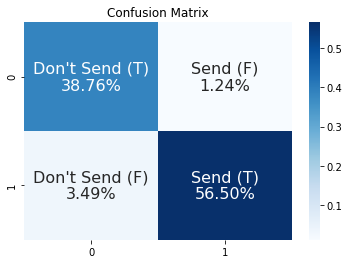

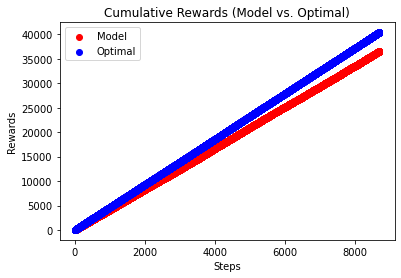

In [18]:
evaluate_model(train_dataloader, data_snippet, model_wide)

# seen users =  8709
# y correct for seen users =  6904
Accuracy of model for seen users = 79.27%
Accuracy of model = 79.27%
Model received 59.95% of the optimal reward
Regret = 16200



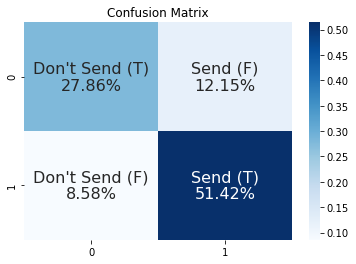

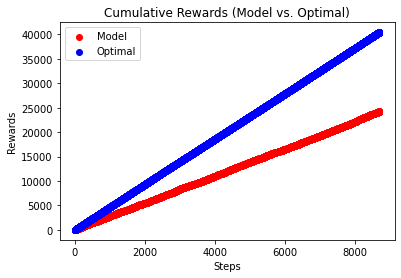

In [19]:
evaluate_model(train_dataloader, data_snippet, model_spnb, take_user_id=False)

# seen users =  8709
# y correct for seen users =  6880
Accuracy of model for seen users = 79.00%
Accuracy of model = 79.00%
Model received 59.79% of the optimal reward
Regret = 16264



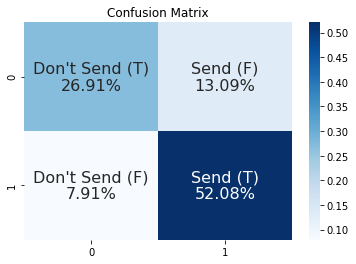

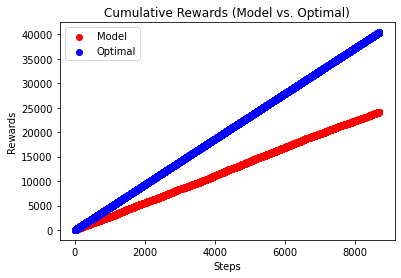

In [20]:
evaluate_model(train_dataloader, data_snippet, model_deep)

# seen users =  8709
# y correct for seen users =  8466
Accuracy of model for seen users = 97.21%
Accuracy of model = 97.21%
Model received 94.96% of the optimal reward
Regret = 2040



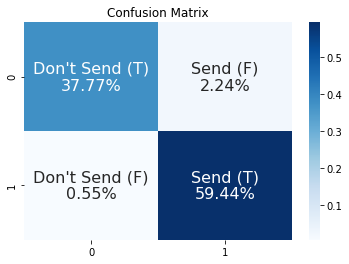

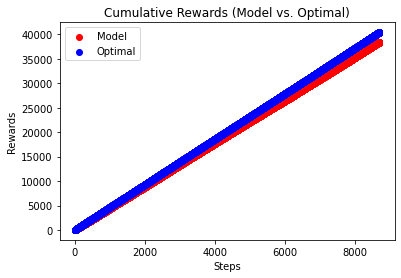

In [21]:
evaluate_model(train_dataloader, data_snippet, model_wide_deep)

# seen users =  83
# y correct for seen users =  66
Accuracy of model for seen users = 79.52%
Accuracy of model = 40.93%
Model received -27.77% of the optimal reward
Regret = 22133



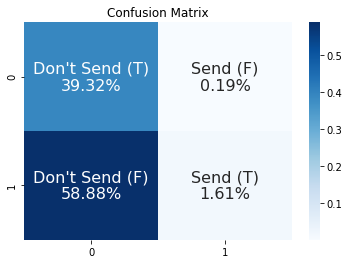

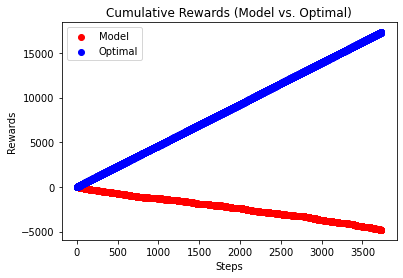

In [22]:
evaluate_model(val_dataloader, data_snippet, model_wide)

# seen users =  83
# y correct for seen users =  73
Accuracy of model for seen users = 87.95%
Accuracy of model = 78.25%
Model received 57.87% of the optimal reward
Regret = 7298



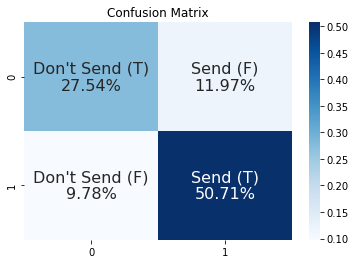

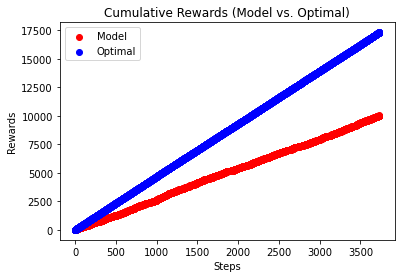

In [23]:
evaluate_model(val_dataloader, data_snippet, model_spnb, take_user_id=False)

# seen users =  83
# y correct for seen users =  73
Accuracy of model for seen users = 87.95%
Accuracy of model = 77.61%
Model received 57.00% of the optimal reward
Regret = 7448



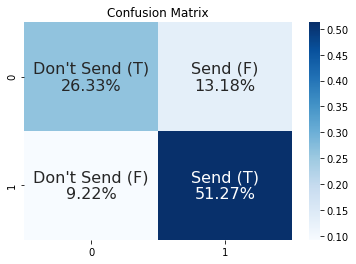

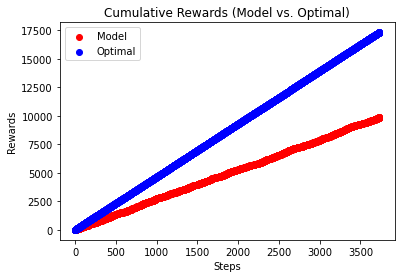

In [24]:
evaluate_model(val_dataloader, data_snippet, model_deep)

# seen users =  83
# y correct for seen users =  72
Accuracy of model for seen users = 86.75%
Accuracy of model = 75.86%
Model received 49.58% of the optimal reward
Regret = 8734



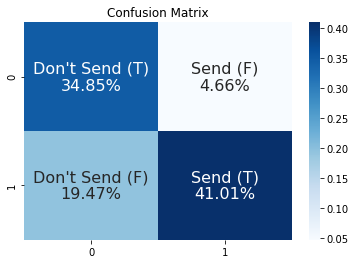

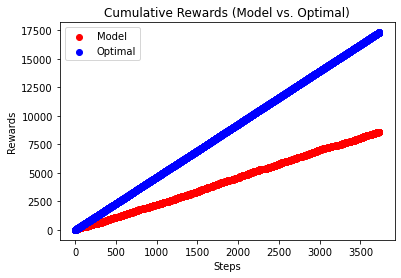

In [25]:
evaluate_model(val_dataloader, data_snippet, model_wide_deep)